In [30]:
# resources:
# https://earthquake.usgs.gov/fdsnws/event/1/   API


In [3]:
import requests
import json
import pandas as pd
import random
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

In [27]:
# open session and explore the api
session = requests.Session()
URL = "https://earthquake.usgs.gov/fdsnws/event/1/application.json"

response = session.get(url=URL)
data = response.json()

print(data.keys())
for key in data.keys():
    print(random.sample(data[key], 10))

dict_keys(['catalogs', 'contributors', 'producttypes', 'eventtypes', 'magnitudetypes'])
['dr', 'ev', 'nc', 'ci', 'is', 'pags', 'ok', 'at', 'ushis', 'ott']
['nc', 'pr', 'ci', 'prod01-pdl01.cr.usgs.gov', 'se', 'nm', 'official', 'av', 'uw', 'us']
['cap', 'image', 'scitech-text', 'trump-ground-failure', 'scitech-link', 'geoserve', 'trump-moment-tensor', 'touch', 'trump-origin', 'focal-mechanism']
['quarry', 'Rock Slide', 'sonic boom', 'not reported', 'collapse', 'acoustic noise', 'nuclear explosion', 'explosion', 'snow_avalanche', 'meteor']
['mh', 'mb_lg', 'MbLg', 'm', 'mint', 'Mi', 'H', 'Ms', 'fa', '4']


In [28]:
# let's get some actual earthquake data
URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"
PARAMS = {
    "eventtype":"earthquake",
    "format":"geojson"
}
response = session.get(url=URL, params=PARAMS)
data = response.json()

print(data.keys())
print(data["metadata"])
print(random.sample(data["features"], 3))
print(len(data["features"]))

dict_keys(['type', 'metadata', 'features', 'bbox'])
{'generated': 1700489282000, 'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventtype=earthquake&format=geojson', 'title': 'USGS Earthquakes', 'status': 200, 'api': '1.14.0', 'count': 9469}
[{'type': 'Feature', 'properties': {'mag': 1.31, 'place': '6 km NW of The Geysers, CA', 'time': 1698016988230, 'updated': 1698473470985, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/nc73950140', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=nc73950140&format=geojson', 'felt': None, 'cdi': None, 'mmi': None, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 26, 'net': 'nc', 'code': '73950140', 'ids': ',nc73950140,', 'sources': ',nc,', 'types': ',focal-mechanism,nearby-cities,origin,phase-data,scitech-link,', 'nst': 39, 'dmin': 0.01145, 'rms': 0.02, 'gap': 31, 'magType': 'md', 'type': 'earthquake', 'title': 'M 1.3 - 6 km NW of The Geysers, CA'}, 'geometry': {'type': 'Point', 'coordinate

In [29]:
# writing it to a json file to look at it
json_string = json.dumps(data["features"], indent=4)
with open("test_request.json", "w") as outfile:
    outfile.write(json_string)

In [52]:
# load json string into a python object
data = json.loads(json_string)

# extract properties and coordinates
properties_list = [item['properties'] for item in data]
coordinates_list = [item['geometry']['coordinates'] for item in data]

# create dfs
properties_df = pd.DataFrame(properties_list)
coordinates_df = pd.DataFrame(coordinates_list, columns=['longitude', 'latitude', 'altitude'])

# concatenate dataframes along columns
result_df = pd.concat([properties_df, coordinates_df], axis=1)

# display resulting df
print(result_df.describe())

               mag          time       updated          felt         cdi  \
count  9469.000000  9.469000e+03  9.469000e+03    547.000000  547.000000   
mean      1.632806  1.699035e+12  1.699390e+12     39.354662    2.753016   
std       1.256051  7.244487e+08  7.057231e+08    515.745797    1.403451   
min      -1.320000  1.697898e+12  1.697898e+12      0.000000    0.000000   
25%       0.830000  1.698414e+12  1.698817e+12      1.000000    2.000000   
50%       1.400000  1.698957e+12  1.699487e+12      1.000000    2.700000   
75%       2.020000  1.699633e+12  1.700012e+12      5.000000    3.550000   
max       7.100000  1.700489e+12  1.700489e+12  11940.000000    8.200000   

              mmi      tsunami          sig          nst         dmin  \
count  125.000000  9469.000000  9469.000000  7464.000000  5914.000000   
mean     3.578504     0.000950    65.667758    23.506967     0.606243   
std      1.802106     0.030817    97.647935    22.379080     1.963763   
min      0.000000     0

In [53]:
# i'm comparing with the file to see if we created the dfs correctly
print(result_df.head())

    mag                                    place           time  \
0  1.73              11 km SW of Volcano, Hawaii  1700489019320   
1  1.82                7 km S of Volcano, Hawaii  1700488798650   
2  1.86             11 km SSW of Volcano, Hawaii  1700488216910   
3  1.73              10 km SW of Volcano, Hawaii  1700488122380   
4  2.10  65 km SE of Pope-Vannoy Landing, Alaska  1700487657697   

         updated    tz                                                url  \
0  1700489200830  None  https://earthquake.usgs.gov/earthquakes/eventp...   
1  1700488982870  None  https://earthquake.usgs.gov/earthquakes/eventp...   
2  1700488547740  None  https://earthquake.usgs.gov/earthquakes/eventp...   
3  1700488454470  None  https://earthquake.usgs.gov/earthquakes/eventp...   
4  1700487756085  None  https://earthquake.usgs.gov/earthquakes/eventp...   

                                              detail  felt  cdi  mmi  ...  \
0  https://earthquake.usgs.gov/fdsnws/event/1/que...   Na

In [54]:
# delete some unused variables
del properties_df, properties_list, coordinates_df, coordinates_list
df = result_df
del result_df

In [55]:
# now let's do some more clean up
# i think we can drop place since we have the coordinates and those are universally comparable, which those place strings are not
# drop updated
# tz is none everywhere, i can't find in the docu what it even is
# url and detail are quasi redundant, we're dropping url
# idk what net is, i can't find it in the docu. should we drop it? but it's the same as sources just without the ticks. i think we should drop source as well as types, type, title
df = df.drop(columns = ["place", "updated", "tz", "url", "sources", "types", "title"])

In [56]:
df["status"].unique()
# can be reduced to boolean

array(['automatic', 'reviewed'], dtype=object)

In [57]:
df["alert"].unique()
# alert needs to be differently encoded

array([None, 'green', 'yellow'], dtype=object)

In [58]:
df["magType"].unique()
# omg are there different magnitude types? let's one_hot encode these and see how it works. maybe we'll need to convert them somehow to have a common unit but idk yet
# https://www.usgs.gov/programs/earthquake-hazards/magnitude-types

array(['md', 'ml', 'ml(texnet)', 'mlv', 'mwr', 'mb', 'mww', 'mb_lg', 'mw',
       'mwb'], dtype=object)

In [59]:
print(df[df["tsunami"] == 1]["ids"].count())
print(df[df["tsunami"] == 0]["ids"].count())
# very serious class imbalance. BUT it's probably just more likely that no tsunami occurs, luckily

9
9460


In [60]:
# TODO ststus boolean
df['status'] = df['status'].map({'automatic': 0, 'reviewed': 1})
# TODO onehot encode alert. note that there are more options than we see in our sample (green, yellow, orange, red, none)
df = pd.get_dummies(df, dummy_na=True, columns=['alert'])
# TODO reserach and decide what to do with magtype
## decided to one-hot encode them as the ranges of the magTypes overlap and are hard to represent as one number
df = pd.get_dummies(df, columns=['magType'])

In [61]:
df.head()

,mag,time,detail,felt,cdi,mmi,status,tsunami,sig,net,...,magType_mb,magType_mb_lg,magType_md,magType_ml,magType_ml(texnet),magType_mlv,magType_mw,magType_mwb,magType_mwr,magType_mww
0,1.73,1700489019320,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,0,0,46,hv,...,False,False,True,False,False,False,False,False,False,False
1,1.82,1700488798650,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,0,0,51,hv,...,False,False,True,False,False,False,False,False,False,False
2,1.86,1700488216910,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,0,0,53,hv,...,False,False,False,True,False,False,False,False,False,False
3,1.73,1700488122380,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,0,0,46,hv,...,False,False,False,True,False,False,False,False,False,False
4,2.10,1700487657697,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,NaN,NaN,0,0,68,ak,...,False,False,False,True,False,False,False,False,False,False


C:\Users\marli\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


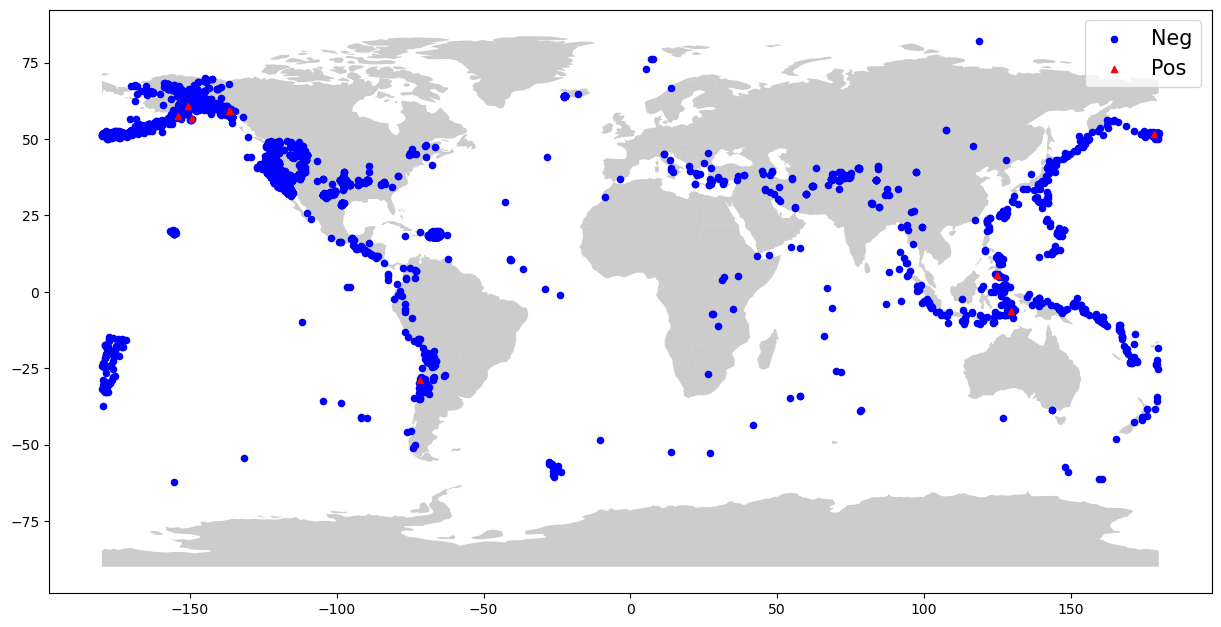

In [62]:
# visualisation
map = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

fig, ax = plt.subplots(figsize=(15,15))
map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['tsunami'] == 0].plot(ax=ax, 
                                       markersize=20, 
                                       color='blue', 
                                       marker='o', 
                                       label='Neg')
geo_df[geo_df['tsunami'] == 1].plot(ax=ax, 
                                       markersize=20, 
                                       color='red', 
                                       marker='^', 
                                       label='Pos')
plt.legend(prop={'size':15})

In [45]:
# also, those are just like 10000 rows. this is little data. let's get some more.
# but i think before we do that it's time to make a remote mongo db instance and store our stuff because i cannot handle tons of data on this machine
# we'll have to make json strings from our dfs, i think, and then store them in mongo